[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\filip\AppData\Local\Temp\ipykernel_7488\927141195.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.07458976 0.08396107 0.0760138  0.05763272 0.04113599]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.weights[cluster_assets] = cluster_weights / self.n_clusters
C:\Users\filip\AppData\Local\Temp\ipykernel_7488\927141195.py:138: FutureWarning: 'M' is deprecated and will b

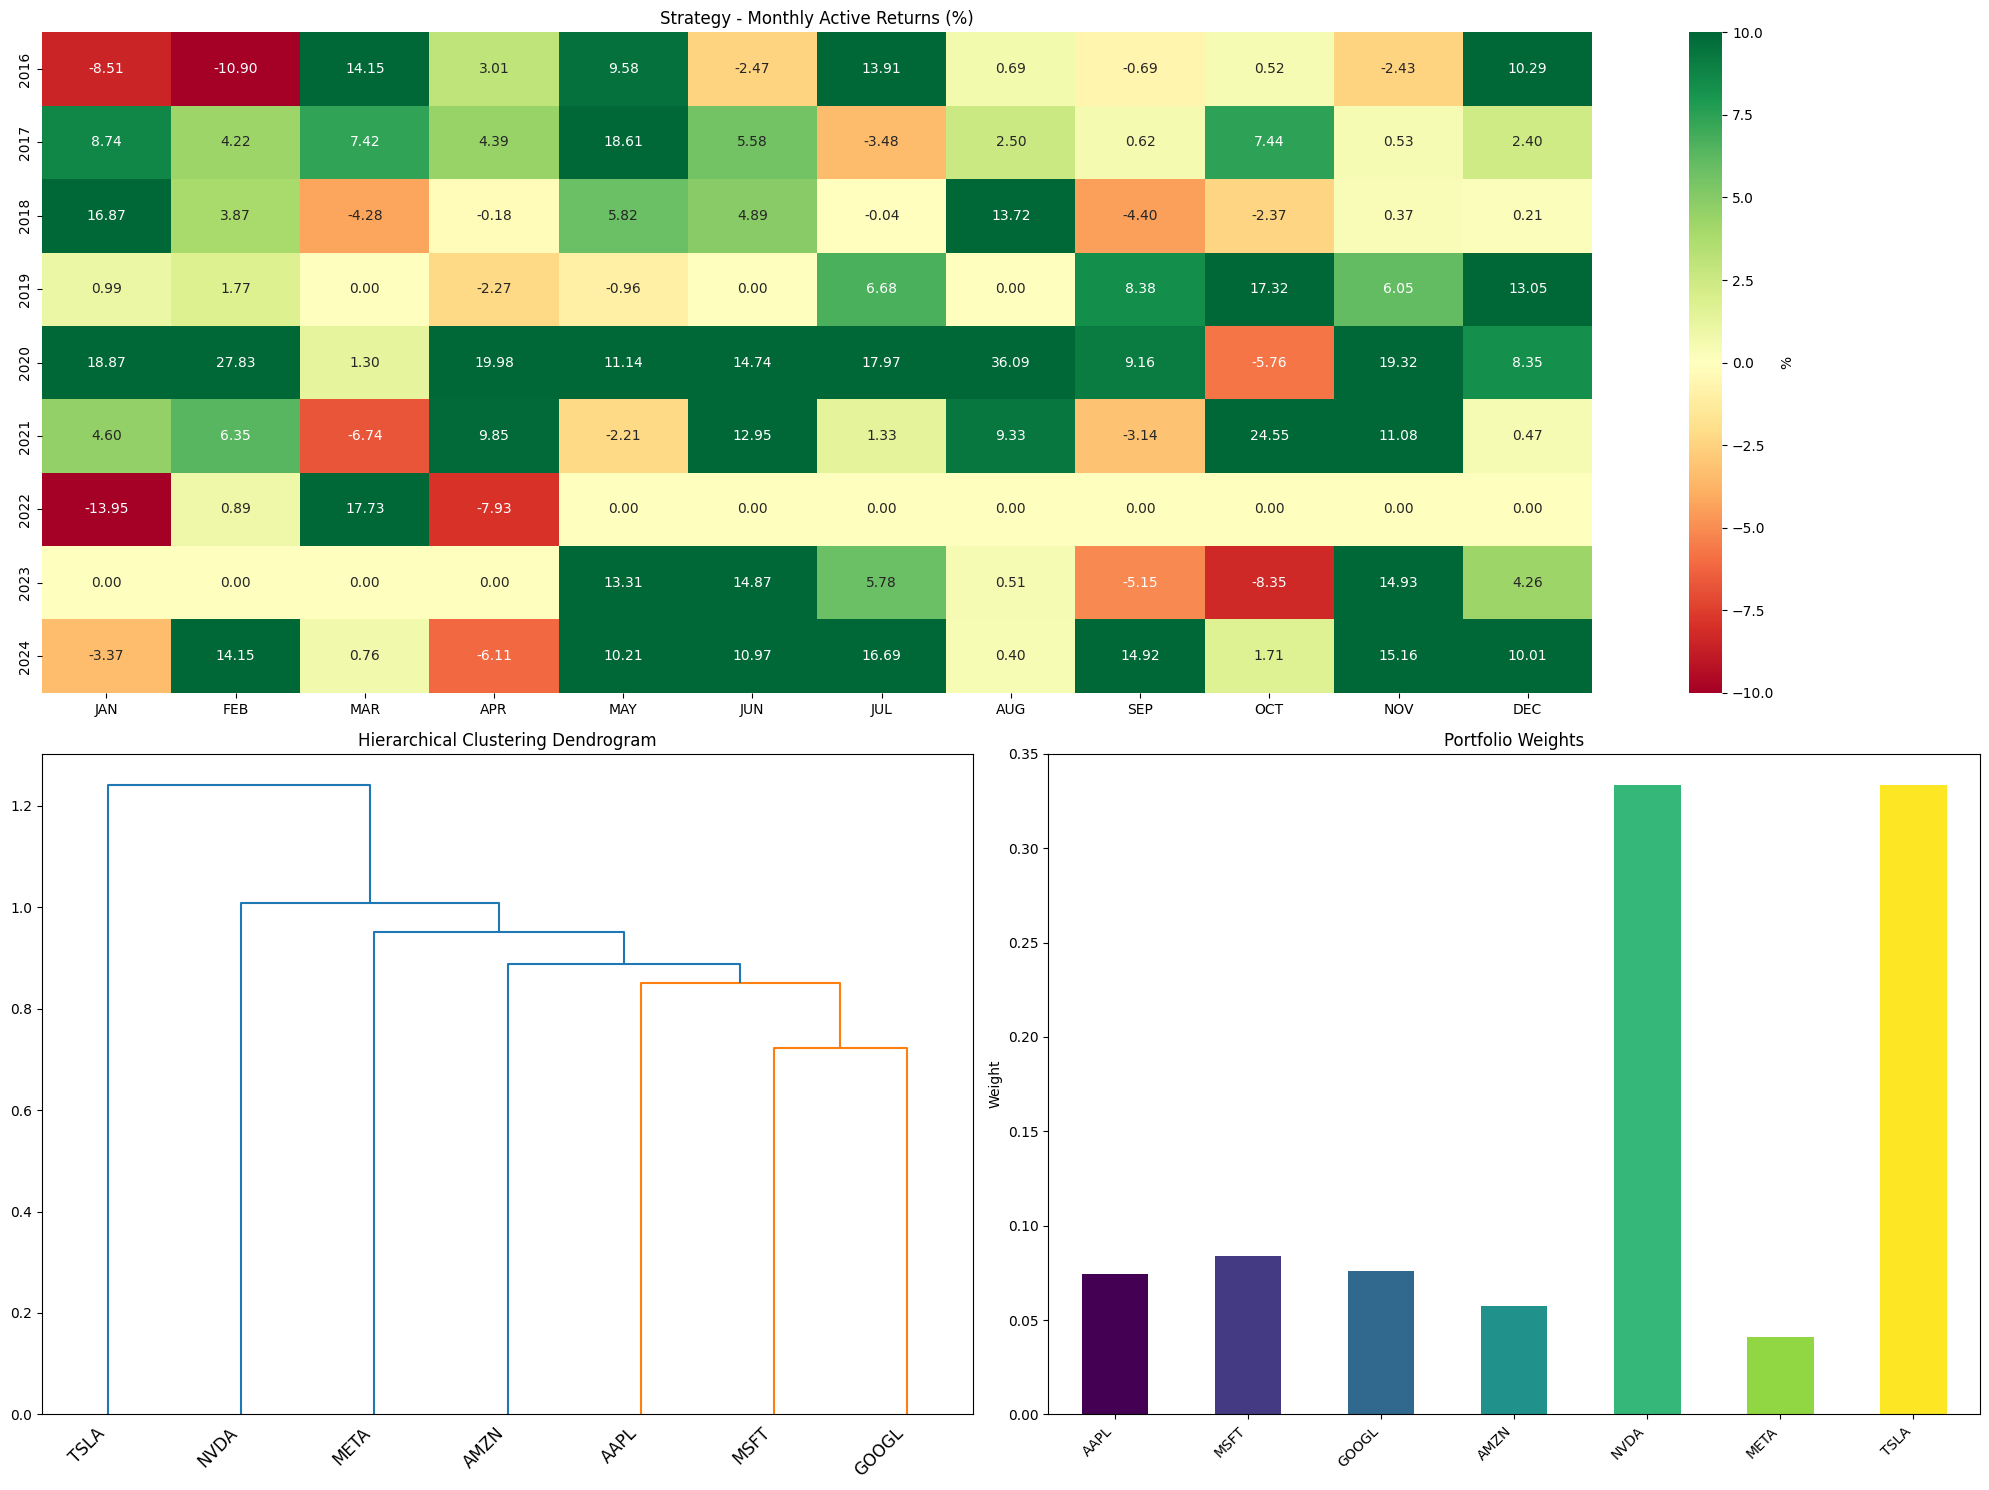

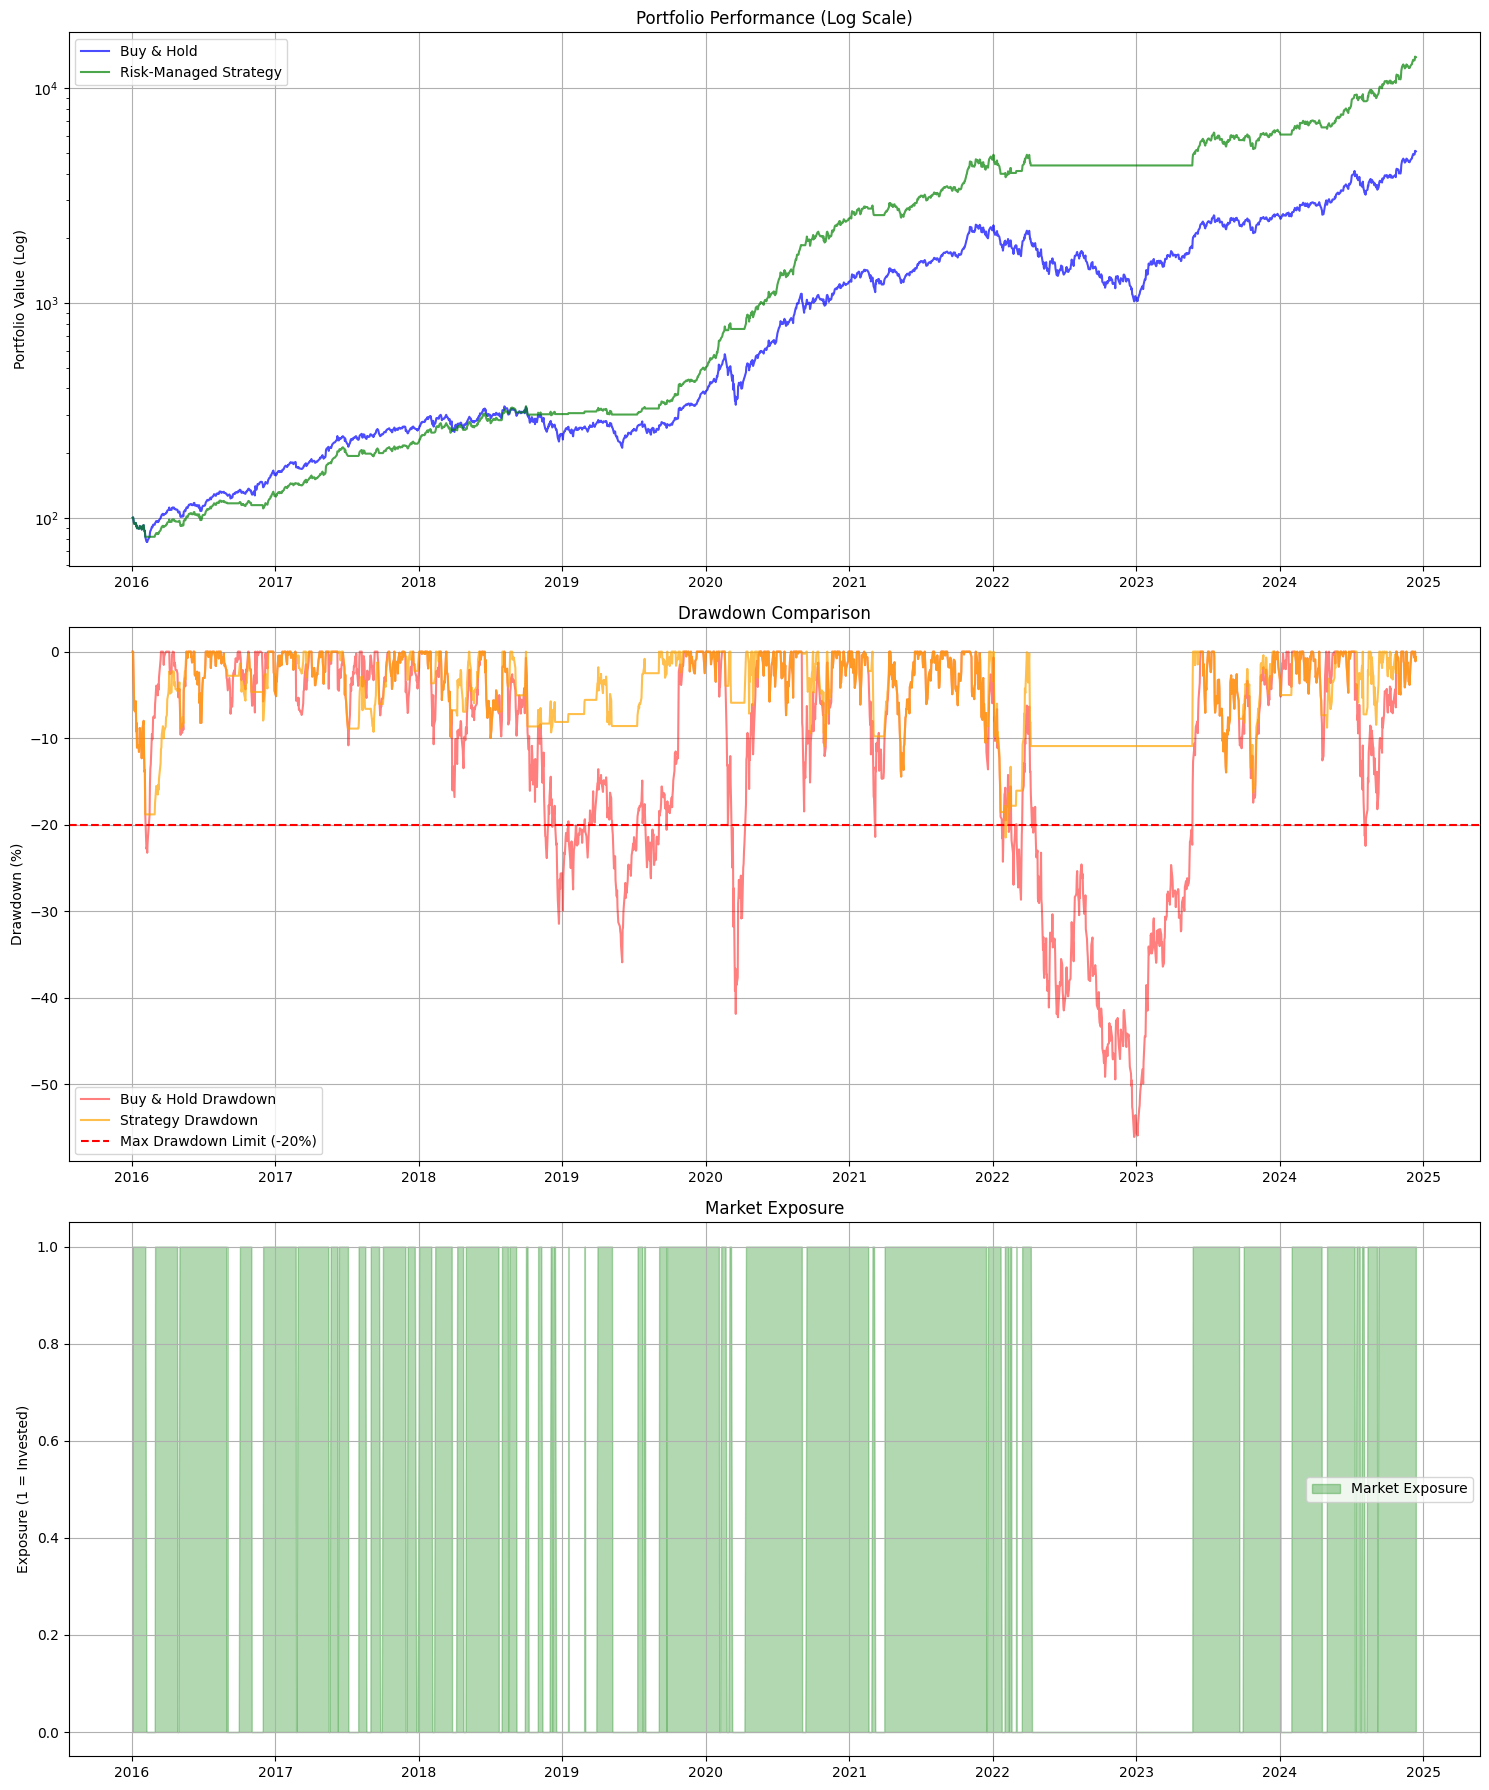


Pesos del Portfolio:
AAPL: 7.46%
MSFT: 8.40%
GOOGL: 7.60%
AMZN: 5.76%
NVDA: 33.33%
META: 4.11%
TSLA: 33.33%

=== Resultados del Backtest (2016-2024) ===

Estadísticas Buy & Hold:
Rendimiento Total: 4976.64%
Rendimiento Anualizado: 55.16%
Volatilidad Anualizada: 36.57%
Ratio de Sharpe: 1.51
Máximo Drawdown: -56.07%
Ratio de Calmar: 0.98

Estadísticas Estrategia con Gestión de Riesgo:
Rendimiento Total: 13836.27%
Rendimiento Anualizado: 73.71%
Volatilidad Anualizada: 24.60%
Ratio de Sharpe: 3.00
Máximo Drawdown: -21.48%
Ratio de Calmar: 3.43
Días en el Mercado: 67.5%
Número de Operaciones: 48


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
plt.style.use('default')

class HRCPortfolioManager:
    def __init__(self, start_date, n_clusters=3, confidence_level=0.99, 
                 window=252, max_drawdown=-20):
        self.start_date = start_date
        self.n_clusters = n_clusters
        self.confidence_level = confidence_level
        self.window = window
        self.max_drawdown = max_drawdown
        self.magnificent_seven = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']
    
    def download_data(self):
        """Descarga y prepara los datos"""
        df_list = []
        for symbol in self.magnificent_seven:
            df = yf.download(symbol, self.start_date)['Adj Close']
            df_list.append(df)
        
        self.prices = pd.concat(df_list, axis=1)
        self.prices.columns = self.magnificent_seven
        self.returns = self.prices.pct_change()
        
        # Añadir información de tiempo
        self.returns['Year'] = self.returns.index.year
        self.returns['Month'] = self.returns.index.month
        self.returns['Week'] = self.returns.index.isocalendar().week
        
        return self.returns
    
    def calculate_clusters(self):
        """Calcula los clusters usando HRC"""
        # Matriz de correlación
        corr_matrix = self.returns[self.magnificent_seven].corr()
        
        # Convertir correlaciones a distancias
        dist_matrix = np.sqrt(2 * (1 - corr_matrix))
        
        # Realizar clustering
        linkage_matrix = linkage(squareform(dist_matrix), method='ward')
        
        # Obtener clusters
        self.clusters = fcluster(linkage_matrix, self.n_clusters, criterion='maxclust')
        
        # Crear diccionario de clusters
        self.cluster_dict = {}
        for i, cluster in enumerate(self.clusters):
            if cluster not in self.cluster_dict:
                self.cluster_dict[cluster] = []
            self.cluster_dict[cluster].append(self.magnificent_seven[i])
            
        return self.cluster_dict
    
    def calculate_weights(self):
        """Calcula los pesos basados en HRC y riesgo"""
        # Calcular varianzas
        variances = self.returns[self.magnificent_seven].var()
        inv_variances = 1 / variances
        
        # Inicializar pesos
        self.weights = pd.Series(0, index=self.magnificent_seven)
        
        # Asignar pesos dentro de cada cluster
        for cluster in self.cluster_dict:
            cluster_assets = self.cluster_dict[cluster]
            cluster_inv_var = inv_variances[cluster_assets]
            cluster_weights = cluster_inv_var / cluster_inv_var.sum()
            self.weights[cluster_assets] = cluster_weights / self.n_clusters
            
        return self.weights
    
    def calculate_portfolio_metrics(self):
        """Calcula las métricas del portfolio con stops temporales"""
        self.portfolio_returns = (self.returns[self.magnificent_seven] * self.weights).sum(axis=1)
        self.portfolio_value = (1 + self.portfolio_returns).cumprod() * 100
        self.rolling_max = self.portfolio_value.expanding().max()
        self.drawdown = ((self.portfolio_value - self.rolling_max) / self.rolling_max) * 100
        
        self.daily_volatility = self.portfolio_returns.rolling(window=self.window).std()
        self.weekly_volatility = self.portfolio_returns.rolling(window=5).std() * np.sqrt(5)
        
        z_score = norm.ppf(1 - self.confidence_level)
        self.daily_var = self.daily_volatility * z_score
        self.weekly_var = self.weekly_volatility * z_score
        self.weekly_returns = self.portfolio_returns.rolling(window=5).sum()
        
        self.risk_signals = pd.DataFrame(index=self.portfolio_returns.index)
        self.risk_signals['Drawdown_Stop'] = self.drawdown < self.max_drawdown
        self.risk_signals['Daily_VaR_Violation'] = self.portfolio_returns < self.daily_var
        
        # Propagar stops
        weekly_stops = []
        current_week = None
        stop_active = False
        
        for idx, row in self.returns.iterrows():
            if row['Week'] != current_week:
                current_week = row['Week']
                stop_active = False
            if self.risk_signals.loc[idx, 'Daily_VaR_Violation']:
                stop_active = True
            weekly_stops.append(stop_active)
        
        self.risk_signals['Weekly_Stop'] = weekly_stops
        self.risk_signals['Weekly_VaR_Violation'] = self.weekly_returns < self.weekly_var
        
        monthly_stops = []
        current_month = None
        stop_active = False
        
        for idx, row in self.returns.iterrows():
            if row['Month'] != current_month:
                current_month = row['Month']
                stop_active = False
            if self.risk_signals.loc[idx, 'Weekly_VaR_Violation']:
                stop_active = True
            monthly_stops.append(stop_active)
        
        self.risk_signals['Monthly_Stop'] = monthly_stops
        self.risk_signals['Final_Stop'] = (
            self.risk_signals['Drawdown_Stop'] |
            self.risk_signals['Weekly_Stop'] |
            self.risk_signals['Monthly_Stop']
        )
        
        return self.risk_signals
    def plot_portfolio_analysis(self, backtest):
        """Visualizaciones mejoradas del portfolio"""
        monthly_returns = backtest['Strategy_Returns'].resample('M').apply(
            lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_matrix = monthly_returns.to_frame()
        monthly_returns_matrix.index = pd.MultiIndex.from_arrays([
            monthly_returns_matrix.index.year,
            monthly_returns_matrix.index.month
        ])
        monthly_returns_pivot = monthly_returns_matrix.pivot_table(
            index=monthly_returns_matrix.index.get_level_values(0),
            columns=monthly_returns_matrix.index.get_level_values(1),
            values='Strategy_Returns'
        )

        fig = plt.figure(figsize=(20, 15))
        
        ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
        sns.heatmap(monthly_returns_pivot, 
                    annot=True, 
                    fmt='.2f',
                    cmap='RdYlGn',
                    center=0,
                    vmin=-10,
                    vmax=10,
                    cbar_kws={'label': '%'})
        ax1.set_title('Strategy - Monthly Active Returns (%)')
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                  'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
        ax1.set_xticklabels(months, rotation=0)
        
        ax2 = plt.subplot2grid((2, 2), (1, 0))
        corr_matrix = self.returns[self.magnificent_seven].corr()
        dist_matrix = np.sqrt(2 * (1 - corr_matrix))
        linkage_matrix = linkage(squareform(dist_matrix), method='ward')
        dendrogram(linkage_matrix, labels=self.magnificent_seven, ax=ax2)
        ax2.set_title('Hierarchical Clustering Dendrogram')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        
        ax3 = plt.subplot2grid((2, 2), (1, 1))
        colors = plt.cm.viridis(np.linspace(0, 1, len(self.magnificent_seven)))
        weights_series = pd.Series(self.weights)
        weights_series.plot(kind='bar', ax=ax3, color=colors)
        ax3.set_title('Portfolio Weights')
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        ax3.set_ylabel('Weight')
        
        plt.tight_layout()
        plt.show()

        # Performance Plot (Log Scale)
        fig, axes = plt.subplots(3, 1, figsize=(15, 18))
        
        axes[0].semilogy(backtest.index, backtest['Buy_Hold_Equity'], 
                        label='Buy & Hold', color='blue', alpha=0.7)
        axes[0].semilogy(backtest.index, backtest['Strategy_Equity'], 
                        label='Risk-Managed Strategy', color='green', alpha=0.7)
        axes[0].set_title('Portfolio Performance (Log Scale)')
        axes[0].set_ylabel('Portfolio Value (Log)')
        axes[0].legend()
        axes[0].grid(True)
        
        axes[1].plot(backtest.index, backtest['BH_Drawdown'], 
                    label='Buy & Hold Drawdown', color='red', alpha=0.5)
        axes[1].plot(backtest.index, backtest['Strategy_Drawdown'], 
                    label='Strategy Drawdown', color='orange', alpha=0.7)
        axes[1].axhline(y=self.max_drawdown, color='r', linestyle='--', 
                        label=f'Max Drawdown Limit ({self.max_drawdown}%)')
        axes[1].set_title('Drawdown Comparison')
        axes[1].set_ylabel('Drawdown (%)')
        axes[1].legend()
        axes[1].grid(True)
        
        axes[2].fill_between(backtest.index, 0, backtest['Position'], 
                           label='Market Exposure', color='green', alpha=0.3)
        axes[2].set_title('Market Exposure')
        axes[2].set_ylabel('Exposure (1 = Invested)')
        axes[2].legend()
        axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()

        print("\nPesos del Portfolio:")
        for asset, weight in self.weights.items():
            print(f"{asset}: {weight:.2%}")

    def backtest_portfolio(self):
        """Realiza el backtesting del portfolio"""
        backtest = pd.DataFrame(index=self.portfolio_returns.index)
        backtest['Returns'] = self.portfolio_returns
        backtest['Risk_Signal'] = self.risk_signals['Final_Stop']
        backtest['Position'] = (~backtest['Risk_Signal']).astype(int)
        backtest['Strategy_Returns'] = backtest['Returns'] * backtest['Position']
        
        initial_capital = 100
        backtest['Buy_Hold_Equity'] = (1 + backtest['Returns']).cumprod() * initial_capital
        backtest['Strategy_Equity'] = (1 + backtest['Strategy_Returns']).cumprod() * initial_capital
        backtest['BH_Drawdown'] = (backtest['Buy_Hold_Equity'] / 
                                  backtest['Buy_Hold_Equity'].expanding().max() - 1) * 100
        backtest['Strategy_Drawdown'] = (backtest['Strategy_Equity'] / 
                                       backtest['Strategy_Equity'].expanding().max() - 1) * 100
        
        # Calcular estadísticas
        trading_days = 252
        total_days = len(backtest)
        years = total_days / trading_days
        
        stats = self._calculate_performance_stats(backtest, years, trading_days, initial_capital)
        self.plot_portfolio_analysis(backtest)
        self._print_performance_stats(stats)
        
        return backtest

    def _calculate_performance_stats(self, backtest, years, trading_days, initial_capital):
        """Calcula estadísticas de rendimiento"""
        bh_total_return = (backtest['Buy_Hold_Equity'].iloc[-1] / initial_capital - 1) * 100
        strategy_total_return = (backtest['Strategy_Equity'].iloc[-1] / initial_capital - 1) * 100
        
        stats = {
            'buy_hold': {
                'total_return': bh_total_return,
                'annual_return': ((1 + bh_total_return/100) ** (1/years) - 1) * 100,
                'volatility': backtest['Returns'].std() * np.sqrt(trading_days) * 100,
                'max_drawdown': backtest['BH_Drawdown'].min()
            },
            'strategy': {
                'total_return': strategy_total_return,
                'annual_return': ((1 + strategy_total_return/100) ** (1/years) - 1) * 100,
                'volatility': backtest['Strategy_Returns'].std() * np.sqrt(trading_days) * 100,
                'max_drawdown': backtest['Strategy_Drawdown'].min(),
                'market_participation': (backtest['Position'].sum() / len(backtest)) * 100,
                'trades': (backtest['Position'] != backtest['Position'].shift(1)).sum() / 2
            }
        }
        
        stats['buy_hold']['sharpe'] = stats['buy_hold']['annual_return'] / stats['buy_hold']['volatility']
        stats['buy_hold']['calmar'] = abs(stats['buy_hold']['annual_return'] / stats['buy_hold']['max_drawdown'])
        stats['strategy']['sharpe'] = stats['strategy']['annual_return'] / stats['strategy']['volatility']
        stats['strategy']['calmar'] = abs(stats['strategy']['annual_return'] / stats['strategy']['max_drawdown'])
        
        return stats

    def _print_performance_stats(self, stats):
        """Imprime estadísticas de rendimiento"""
        print("\n=== Resultados del Backtest (2016-2024) ===")
        print("\nEstadísticas Buy & Hold:")
        print(f"Rendimiento Total: {stats['buy_hold']['total_return']:.2f}%")
        print(f"Rendimiento Anualizado: {stats['buy_hold']['annual_return']:.2f}%")
        print(f"Volatilidad Anualizada: {stats['buy_hold']['volatility']:.2f}%")
        print(f"Ratio de Sharpe: {stats['buy_hold']['sharpe']:.2f}")
        print(f"Máximo Drawdown: {stats['buy_hold']['max_drawdown']:.2f}%")
        print(f"Ratio de Calmar: {stats['buy_hold']['calmar']:.2f}")
        
        print("\nEstadísticas Estrategia con Gestión de Riesgo:")
        print(f"Rendimiento Total: {stats['strategy']['total_return']:.2f}%")
        print(f"Rendimiento Anualizado: {stats['strategy']['annual_return']:.2f}%")
        print(f"Volatilidad Anualizada: {stats['strategy']['volatility']:.2f}%")
        print(f"Ratio de Sharpe: {stats['strategy']['sharpe']:.2f}")
        print(f"Máximo Drawdown: {stats['strategy']['max_drawdown']:.2f}%")
        print(f"Ratio de Calmar: {stats['strategy']['calmar']:.2f}")
        print(f"Días en el Mercado: {stats['strategy']['market_participation']:.1f}%")
        print(f"Número de Operaciones: {stats['strategy']['trades']:.0f}")

if __name__ == "__main__":
    portfolio_manager = HRCPortfolioManager('2016-01-01')
    returns = portfolio_manager.download_data()
    clusters = portfolio_manager.calculate_clusters()
    weights = portfolio_manager.calculate_weights()
    risk_signals = portfolio_manager.calculate_portfolio_metrics()
    backtest_results = portfolio_manager.backtest_portfolio()